In [11]:
import json
import matplotlib.pyplot as plt

In [12]:
# open file and read data
f = open("flamegraph.json")
data = json.load(f)[0]
synth = data['spans'][0]

In [13]:
# create dict to store time stats
funcs = ['update_parentheses', 'is_inside_or',
         'match_all', 'match_none', 'extend', 'is_duplicate', 'insert_table', 'push', 'find_occurrences', 'init_state']
times_called = {k: 0 for k in funcs}
stats = {k: 0 for k in funcs}
stats['synth'] = synth['delta']

In [14]:
# a summation of time of all functions called
def recursive_add_time(function):
    # dict_keys(['name', 'start_ns', 'end_ns', 'delta', 'depth', 'children', 'notes'])
    if function['children']:
        for subfunctions in function['children']:
            func_name = subfunctions['name']
            func_time = subfunctions['delta']
            stats[func_name] += func_time
            times_called[func_name] += 1 
            recursive_add_time(subfunctions)


recursive_add_time(synth)
print(stats)

{'update_parentheses': 14252853, 'is_inside_or': 17565009, 'match_all': 217798756, 'match_none': 15119751, 'extend': 192483182, 'is_duplicate': 24016151, 'insert_table': 40735914, 'push': 10858652, 'find_occurrences': 0, 'init_state': 18832416, 'synth': 444007167}


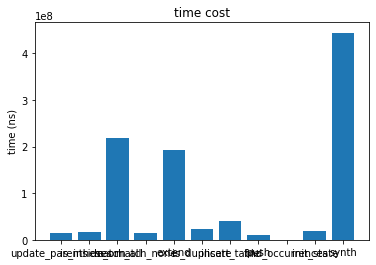

In [15]:
# draw plot
fig, ax = plt.subplots()
ax.bar(stats.keys(), stats.values())
ax.set_ylabel('time (ns)')
ax.set_title('time cost')

plt.show()

In [17]:
ratio_of_each = {k:round(v/stats['synth'], 2) for (k,v) in stats.items()}
"""
extend + matchall + matchnone = 0.97 synth
"""
ratio_of_each
"""
{'update_parentheses': 0.08,
 'is_inside_or': 0.1,
 'match_all': 0.04,
 'match_none': 0.0,
 'extend': 0.91,
 'is_duplicate': 0.18,
 'insert_table': 0.11,
 'push': 0.03,
 'find_occurrences': 0.02,
 'init_state': 0.05,
 'synth': 1.0}
"""
ratio_of_each


{'update_parentheses': 0.03,
 'is_inside_or': 0.04,
 'match_all': 0.49,
 'match_none': 0.03,
 'extend': 0.43,
 'is_duplicate': 0.05,
 'insert_table': 0.09,
 'push': 0.02,
 'find_occurrences': 0.0,
 'init_state': 0.04,
 'synth': 1.0}

In [18]:
"""
{'update_parentheses': 2231460,
 'is_inside_or': 2231460,
 'match_all': 1128,
 'match_none': 147,
 'extend': 116782,
 'is_duplicate': 2231460,
 'insert_table': 884406,
 'push': 884406,
 'find_occurrences': 116782,
 'init_state': 884406}
"""
times_called

{'update_parentheses': 57810,
 'is_inside_or': 57810,
 'match_all': 1128,
 'match_none': 147,
 'extend': 11562,
 'is_duplicate': 57810,
 'insert_table': 53522,
 'push': 53522,
 'find_occurrences': 0,
 'init_state': 53522}

In [20]:
"""
{'update_parentheses': 237.05256155162988,
 'is_inside_or': 296.4919505615158,
 'match_all': 206824.1329787234,
 'match_none': 105825.6530612245,
 'extend': 49671.88202805227,
 'is_duplicate': 505.50786480600146,
 'insert_table': 771.1694097507253,
 'push': 200.43621255396278,
 'find_occurrences': 846.6527547053485,
 'init_state': 335.48012677435474}
"""
del times_called['find_occurrences']
avg_execution_time_ns = {k: stats[k]/v for k, v in times_called.items()}
avg_execution_time_ns


{'update_parentheses': 246.5464971458225,
 'is_inside_or': 303.84032174364296,
 'match_all': 193084.0035460993,
 'match_none': 102855.44897959183,
 'extend': 16647.914028714757,
 'is_duplicate': 415.43246843106726,
 'insert_table': 761.1059751130376,
 'push': 202.88202981951346,
 'init_state': 351.86308433915025}

In [21]:
stats

{'update_parentheses': 14252853,
 'is_inside_or': 17565009,
 'match_all': 217798756,
 'match_none': 15119751,
 'extend': 192483182,
 'is_duplicate': 24016151,
 'insert_table': 40735914,
 'push': 10858652,
 'find_occurrences': 0,
 'init_state': 18832416,
 'synth': 444007167}

In [7]:
print((stats['is_inside_or']+stats['update_parentheses']+stats['is_duplicate']+stats['insert_table']+stats['push']+stats['init_state'])/stats['extend'])
# print(stats['extend'])

0.5989879398197877


In [ ]:
print("find_parentheses/is_inside_or = ", round(stats['find_parentheses']/stats['is_inside_or'], 2))
print("is_inside_or/extend = ", round(stats['is_inside_or']/stats['extend'], 2))


In [38]:
stats['find_occurrences']

1016804

## Time efficiency of state processing

### todo:
* 計算到達不同cost(20-30)的時間＋相關數據/圖
* try pruning while time to cost calculation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
df = pd.read_csv('stats.csv')
df = df.set_index('cost')
df.head()

,sec,state_num
cost,,
1,0.000699,2
2,0.000920,7
3,0.001259,22
4,0.002798,83
5,0.010302,322


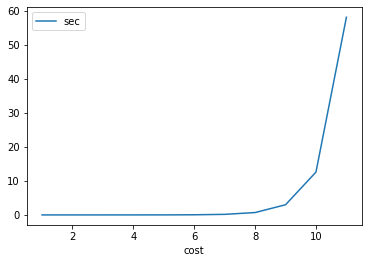

In [14]:
lines = df[['sec']].plot.line()

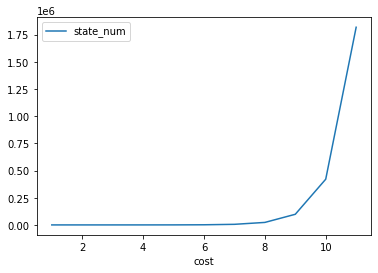

In [15]:
lines = df[['state_num']].plot.line()